# 1. Introduction to Deterministic Lake with Pytorch and Bellman

In [1]:
import gym
import time
import matplotlib.pyplot as plt
import torch

from gym.envs.registration import register

%config InlineBackend.figure_format = 'retina'

#### To make this a Deterministic, rather than a Stochastic, environment we set the "is_slippery" line to False. Also, OpenGym will not let you register over am already registed enviornment. Comment these lines over once you have run. 

In [2]:
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 
            'is_slippery': False},
)

In [3]:
env = gym.make('FrozenLakeNotSlippery-v0')
# env = gym.wrappers.Monitor(env, videos_dir)
# videos_dir = "./videos"

#### If you see an error above, then try:

In [4]:
#pip uninstall -y scipy scikit-learn
#pip install --no-binary scipy scikit-learn

#### Notice in this space, the actor has to navigate a 4x4 grid populated with holes labeled "H" to make it to the goal labeled "G". For this model, lets assume that our actor cannot leave the field, so impossible moves will be considered as a pass.

<img src="./DLake.png">

#### For gym, instructions are given as: <br><br> LEFT = 0 <br> DOWN = 1 <br> RIGHT = 2 <br> UP = 3

In [5]:
# 4x4 space works out to be 16 possible states for the actor
env.observation_space.n

16

In [6]:
# The actor can choose one of four posisbilities, up, down, left, and right, invalid actions that would force the
# actor off the space would be ignored. However, the actor can fall down into the hole, ending the game.
env.action_space.n

4

# 2. Algorithm for deterministic environment 

#### The code below will only work for Deterministic environments were the agents movements will not be randomized. 

In [7]:
#Initilize Q
number_of_states = env.observation_space.n
number_of_actions = env.action_space.n

# At first Q is a zero tensor with action and observation space
Q = torch.zeros([number_of_states, number_of_actions])

# Initilize Gamma
gamma = 1

#### Another way to think about the Q tensor is that we have 16 states, each where we can choose from 4 possible actions

In [8]:
# This is a 16x4 tensor
Q.size()

torch.Size([16, 4])

#### For the Bellman equation, we will consider the max best move for any state. To visulize this with Pytorch, imagine a state where RIGHT is the best choice with reward value of .9:

In [9]:
#[L,D,R,U]
a = torch.tensor([[.4,.1,.9,.4]])

#### To pull the max value from the tensor

In [10]:
torch.max(a,1)

(tensor([0.9000]), tensor([2]))

In [11]:
a[0][2]

tensor(0.9000)

# 3. The Loop

tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.]])


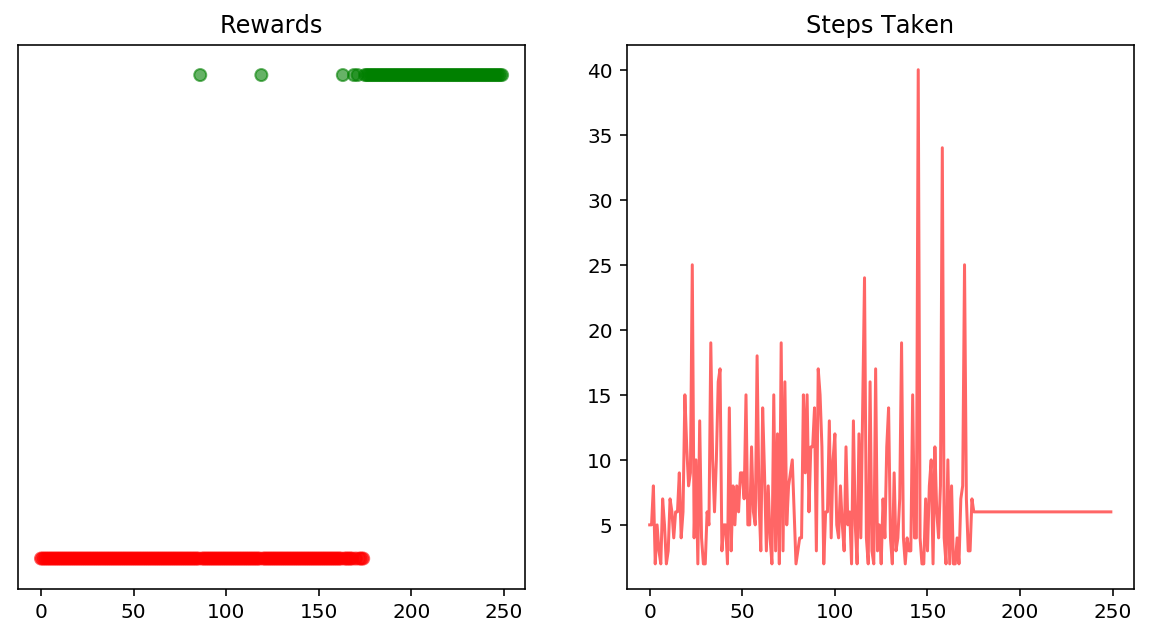

In [12]:
num_episodes = 250

# Lists of the values from each trial
steps_total = []
rewards_total = []

#scale factor for random values
s = 100

for i_episode in range(num_episodes):
    
    #Uncomment if you want to watch the actions
    #print("Episode #{}\n\n\n".format(i_episode))
    
    #Resest gamespace
    state = env.reset()
    step = 0
    #for step in range(100):
    while True:
        
        step += 1  
        # action 
        random_values = Q[state] + torch.rand(1,number_of_actions) / s
        
        #set the best action from the list
        action = torch.max(random_values,1)[1][0]
        
        #Take the best action
        new_state, reward, done, info = env.step(action.item())
        
        #Update Q and state
        Q[state, action] = reward + gamma * torch.max(Q[new_state])
        state = new_state
        
        #Uncomment if you want to watch the actions
        #env.render()

        if done:
            steps_total.append(step)
            rewards_total.append(reward)
            break
        
print(Q)

figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5));

colors = ["red" if x < 1 else "green" for x in rewards_total]
ax[0].set_title("Rewards");
ax[0].scatter(torch.arange(len(rewards_total)),
              rewards_total,
              alpha=0.6,
              color=colors);
ax[0].set_yticks([])

ax[1].set_title("Steps Taken");
ax[1].plot(range(len(steps_total)),steps_total, alpha=0.6, color='red');